# **Import Library**

In [4]:
!pip install Sastrawi
!pip install nltk

import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score

import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Load Dataset**

In [5]:
df = pd.read_csv('/content/gojek_reviews.csv')

# **Data Understanding**

In [6]:
df.head()

,content,score
0,"akhir"" ini slalu mendapatkan driver yg kurang ...",1
1,Nice,5
2,bagus,5
3,"mahal banget,makin kesini makan kerasa ongkir nya",1
4,tanpa ribet jalan jauh..😁😁👍🏻 ada gojek jmput d...,5


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  25000 non-null  object
 1   score    25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [9]:
print(df.isna().sum())

content    0
score      0
dtype: int64


In [10]:
df.duplicated().sum()

np.int64(6631)

# **Data Preprocessing**

In [11]:
duplikat_sebelum = df.duplicated().sum()

df = df.drop_duplicates()

duplikat_setelah = df.duplicated().sum()

print(f"Jumlah data setelah duplikat dihapus: {len(df)}")
print(f"Jumlah data duplikat yang dihapus: {duplikat_sebelum}")

Jumlah data setelah duplikat dihapus: 18369
Jumlah data duplikat yang dihapus: 6631


In [12]:
slangwords = {
    "yg": "yang", "gk": "tidak", "gak": "tidak", "ga": "tidak",
    "aja": "saja", "kalo": "kalau", "bgt": "banget", "pake": "pakai",
    "biar": "supaya", "jm": "jam", "drivernya": "driver nya", "resto": "restoran",
    "mantappp": "mantap", "ok": "oke", "sama": "dengan", "makin": "semakin",
    "cancel": "batalkan", "nunggu": "menunggu", "tau": "tahu", "lah": "",
    "ya": "", "nya": "", "udah": "sudah", "bagusss": "bagus", "membantuuu": "membantu",
    "sukaa": "suka", "bangettt": "banget", "best": "terbaik", "good": "bagus",
    "oke": "bagus", "kyaknya": "sepertinya", "mantulll": "mantul", "paraahhh": "parah"
}

In [13]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s,]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

def casefoldingText(text):
    return text.lower()

def fix_slangwords(text):
    return ' '.join(slangwords.get(word.lower(), word) for word in text.split())

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian')).union(stopwords.words('english'))
    listStopwords.update([
        'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'di', 'ga', 'ya', 'gaa',
        'loh', 'kah', 'woi', 'woii', 'woy', 'wlw', 'jek', 'hemmm', 'oi', 'wahh',
        'aja', 'dong', 'deh', 'mah', 'tuh', 'yah', 'nyah', 'nyahnya', 'lagih',
        'nyamau', 'pokonya', 'poko', 'ojol', 'reguler'
    ])
    return [word for word in text if word not in listStopwords]

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmingText(words):
    return [stemmer.stem(word) for word in words]

def toSentence(list_words):
    return ' '.join(list_words)

In [15]:
df['text_clean'] = df['content'].apply(cleaningText)
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

from tqdm import tqdm
from functools import lru_cache

tqdm.pandas()

@lru_cache(maxsize=10000)
def stem_cached(word):
    return stemmer.stem(word)

def stemmingText(words):
    return [stem_cached(word) for word in words]

df['text_stemming'] = df['text_stopword'].progress_apply(stemmingText)

df['text_akhir'] = df['text_stemming'].apply(toSentence)
df = df[df['text_akhir'].str.strip() != '']

100%|██████████| 18369/18369 [29:08<00:00, 10.51it/s]


In [16]:
import requests

def get_lexicon_data(link):
    hasil = requests.get(link)
    if hasil.ok:
        baris = hasil.text.splitlines()
        return set(kata.strip() for kata in baris if kata.strip())
    print(f"Gagal mengambil data dari {link}, status: {hasil.status_code}")
    return set()

daftar_lexicon = {
    "positif": "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/positive.txt",
    "negatif": "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/negative.txt"
}

kamus_kata = {}
for kategori, tautan in daftar_lexicon.items():
    kamus_kata[kategori] = get_lexicon_data(tautan)

for jenis_sentimen, kumpulan_kata in kamus_kata.items():
    print(f"Jumlah kata {jenis_sentimen}: {len(kumpulan_kata)}")

Jumlah kata positif: 1182
Jumlah kata negatif: 2402


In [17]:
def analisis_sentimen(teks):
    skor = sum(
        (1 if kata in kamus_kata["positif"] else -1 if kata in kamus_kata["negatif"] else 0)
        for kata in teks
    )
    label = "positive" if skor > 0 else "negative" if skor < 0 else "neutral"
    return skor, label

hasil_sentimen = df['text_stemming'].apply(analisis_sentimen)
skor_list, label_list = zip(*hasil_sentimen)
df['skor_polaritas'] = skor_list
df['label_sentimen'] = label_list

print(df['label_sentimen'].value_counts())

label_sentimen
neutral     8258
positive    6875
negative    3007
Name: count, dtype: int64


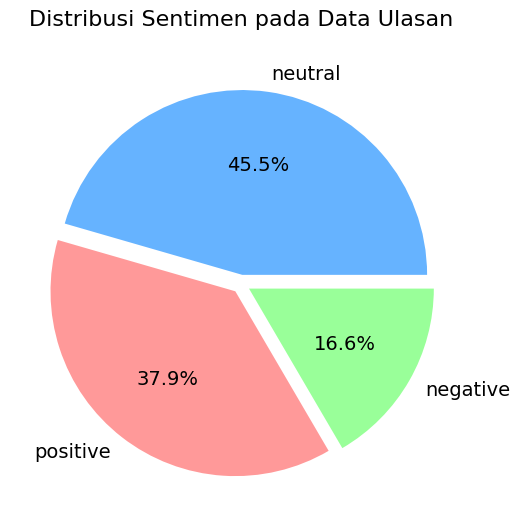

In [18]:
warna_sentimen = ['#66b3ff', '#ff9999', '#99ff99']

gambar, sumbu = plt.subplots(figsize=(6, 6))

jumlah_per_sentimen = df['label_sentimen'].value_counts().values
kategori_sentimen = df['label_sentimen'].value_counts().index.tolist()

jarak_irisan = [0.05 for _ in kategori_sentimen]

sumbu.pie(
    x=jumlah_per_sentimen,
    labels=kategori_sentimen,
    colors=warna_sentimen[:len(kategori_sentimen)],
    autopct='%1.1f%%',
    explode=jarak_irisan,
    textprops={'fontsize': 14}
)

sumbu.set_title('Distribusi Sentimen pada Data Ulasan', fontsize=16, pad=20)

plt.show()


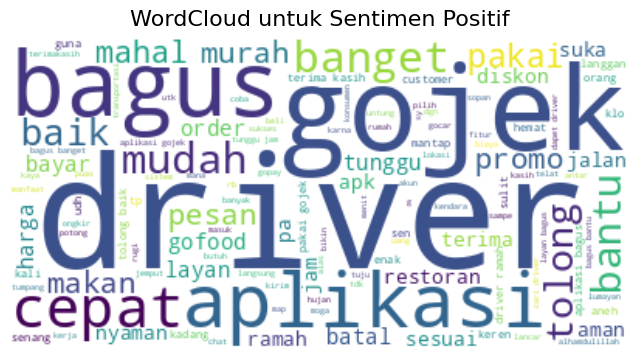

In [20]:
teks_positif = df[df['label_sentimen'] == 'positive']['text_akhir']

teks_gabungan = ' '.join(teks_positif.astype(str).tolist())

wordcloud_positif = WordCloud(background_color='white').generate(teks_gabungan)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud untuk Sentimen Positif', fontsize=16, pad=10)
plt.show()

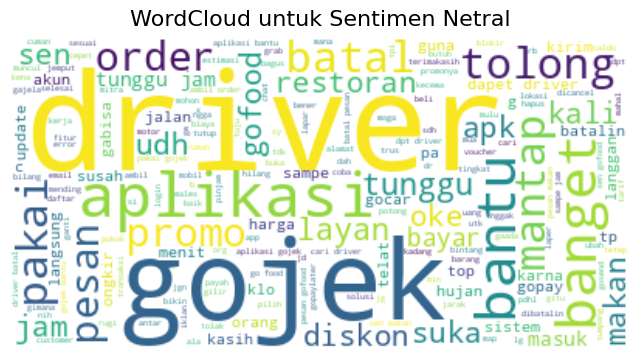

In [19]:
teks_netral = df[df['label_sentimen'] == 'neutral']['text_akhir']

gabungan_teks = ' '.join(teks_netral.astype(str).tolist())

wordcloud_netral = WordCloud(background_color='white').generate(gabungan_teks)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_netral, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud untuk Sentimen Netral', fontsize=16, pad=10)
plt.show()

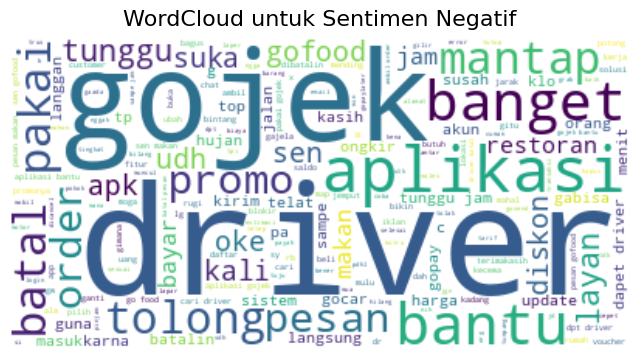

In [22]:
teks_negatif = df[df['label_sentimen'] == 'negative']['text_akhir']

gabungan_teks = ' '.join(teks_netral.astype(str).tolist())

wordcloud_netral = WordCloud(background_color='white').generate(gabungan_teks)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_netral, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud untuk Sentimen Negatif', fontsize=16, pad=10)
plt.show()

<ipython-input-24-f21545b072a7>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


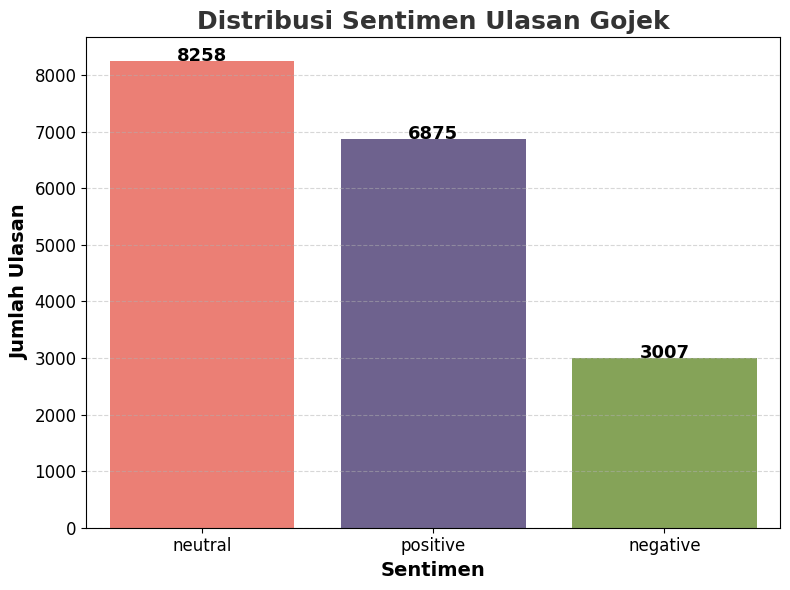

In [24]:
jumlah_sentimen = df['label_sentimen'].value_counts()
kategori = jumlah_sentimen.index
nilai = jumlah_sentimen.values

warna = ['#ff6f61', '#6b5b95', '#88b04b']

plt.figure(figsize=(8, 6))

bar = sns.barplot(
    x=kategori,
    y=nilai,
    palette=warna[:len(kategori)]
)

for i, val in enumerate(nilai):
    plt.text(i, val + 0.5, str(val), ha='center', fontsize=13, fontweight='bold', color='black')

plt.title("Distribusi Sentimen Ulasan Gojek", fontsize=18, fontweight='bold', color='#333')
plt.xlabel("Sentimen", fontsize=14, fontweight='semibold')
plt.ylabel("Jumlah Ulasan", fontsize=14, fontweight='semibold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# **Modelling**

In [25]:
fitur_teks = df['text_akhir'].astype(str)
label_sentimen = df['label_sentimen'].replace({'neutral': 0, 'negative': 1, 'positive': 2})


<ipython-input-25-0645607166b7>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  label_sentimen = df['label_sentimen'].replace({'neutral': 0, 'negative': 1, 'positive': 2})


In [26]:
vektor_tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), max_df=0.9)

fitur_tfidf = vektor_tfidf.fit_transform(fitur_teks)

# **Model RF, IF-TDF, dan 80/20 Split**

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    fitur_tfidf,
    label_sentimen,
    test_size=0.2,
    stratify=label_sentimen,
    random_state=42
)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

acc_train_rf = accuracy_score(y_train, y_pred_train_rf)
acc_test_rf = accuracy_score(y_test, y_pred_test_rf)

f1_rf = f1_score(y_test, y_pred_test_rf, average='macro')

print(f"Akurasi Training Set (Random Forest): {acc_train_rf:.2%}")
print(f"Akurasi Testing Set (Random Forest): {acc_test_rf:.2%}")
print(f"F1-Score (Random Forest): {f1_rf:.2%}")
print("\nClassification Report (Random Forest - Testing Set):")
print(classification_report(y_test, y_pred_test_rf))

Akurasi Training Set (Random Forest): 99.95%
Akurasi Testing Set (Random Forest): 86.80%
F1-Score (Random Forest): 84.68%

Classification Report (Random Forest - Testing Set):
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1652
           1       0.86      0.68      0.76       601
           2       0.91      0.90      0.91      1375

    accuracy                           0.87      3628
   macro avg       0.87      0.83      0.85      3628
weighted avg       0.87      0.87      0.87      3628



# **Model SVM, IF-TDF, dan 70/30 Split**

In [74]:
X_train, X_test, y_train, y_test_svm = train_test_split(
    fitur_tfidf, label_sentimen, test_size=0.3, stratify=label_sentimen, random_state=42
)

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

y_pred_train = svm_model.predict(X_train)
y_pred_test_svm = svm_model.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test_svm = accuracy_score(y_test_svm, y_pred_test_svm)

f1_svm = f1_score(y_test_svm, y_pred_test_svm, average='macro')

print("Akurasi Model pada Testing Set (SVM):", acc_test_svm)
print("\nClassification Report (SVM - Testing Set):\n", classification_report(y_test_svm, y_pred_test_svm))
print(f"Akurasi Training Set (SVM): {acc_train:.2%}")
print(f"Akurasi Testing Set (SVM): {acc_test_svm:.2%}")
print(f"F1-Score SVM: {f1_svm:.2%}")

Akurasi Model pada Testing Set (SVM): 0.9059169423006248

Classification Report (SVM - Testing Set):
               precision    recall  f1-score   support

           0       0.86      0.95      0.90      2477
           1       0.92      0.75      0.83       902
           2       0.97      0.92      0.94      2063

    accuracy                           0.91      5442
   macro avg       0.91      0.87      0.89      5442
weighted avg       0.91      0.91      0.91      5442

Akurasi Training Set (SVM): 98.05%
Akurasi Testing Set (SVM): 90.59%
F1-Score SVM: 89.06%


# **Model LSTM, Tokenizing, Padding, dan 80/20 Split**

In [76]:
le = LabelEncoder()
y = le.fit_transform(label_sentimen)

tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(fitur_teks)

sequences = tokenizer.texts_to_sequences(fitur_teks)
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

X_train, X_test, y_train, y_test_lstm = train_test_split(
    padded_sequences, y, test_size=0.2, stratify=y, random_state=42
)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=15,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

y_pred_train_probs = model.predict(X_train)
y_pred_test_probs = model.predict(X_test)

y_pred_train = np.argmax(y_pred_train_probs, axis=1)
y_pred_test_lstm = np.argmax(y_pred_test_probs, axis=1)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test_lstm = accuracy_score(y_test_lstm, y_pred_test_lstm)

f1_lstm = f1_score(y_test_lstm, y_pred_test_lstm, average='macro')

print("Akurasi Model pada Testing Set (BiLSTM):", acc_test_lstm)
print("\nClassification Report (BiLSTM - Testing Set):\n", classification_report(y_test_lstm, y_pred_test_lstm))

print(f"Akurasi Training Set (BiLSTM): {acc_train:.2%}")
print(f"Akurasi Testing Set (BiLSTM): {acc_test_lstm:.2%}")
print(f"F1-Score LSTM: {f1_lstm:.2%}")

Epoch 1/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 102s 438ms/step - accuracy: 0.5803 - loss: 0.8340 - val_accuracy: 0.9105 - val_loss: 0.2522
Epoch 2/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 146s 459ms/step - accuracy: 0.9301 - loss: 0.1789 - val_accuracy: 0.9339 - val_loss: 0.1901
Epoch 3/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 136s 661ms/step - accuracy: 0.9702 - loss: 0.0782 - val_accuracy: 0.9401 - val_loss: 0.1871
Epoch 4/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 117s 538ms/step - accuracy: 0.9834 - loss: 0.0434 - val_accuracy: 0.9587 - val_loss: 0.1395
Epoch 5/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 114s 405ms/step - accuracy: 0.9926 - loss: 0.0198 - val_accuracy: 0.9518 - val_loss: 0.1965
Epoch 6/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 145s 421ms/step - accuracy: 0.9946 - loss: 0.0152 - val_accuracy: 0.9421 - val_loss: 0.1818
Epoch 7/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 138s 400ms/step - accuracy: 0.9935 - loss: 0.0173 - val_accuracy: 0.9566 - val_loss: 0.1882
454/454 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 6

# **Perbandingan Hasil Evaluasi 3 Model**

In [78]:
f1_rf = f1_score(y_test, y_pred_test, average='macro')
f1_svm = f1_score(y_test_svm, y_pred_test_svm, average='macro')
f1_lstm = f1_score(y_test_lstm, y_pred_test_lstm, average='macro')

results = [
    {
        'Model': 'Random Forest',
        'Accuracy': acc_test,
        'F1-Score': f1_rf,
        'Split Ratio': '70/30',
        'Feature Type': 'TF-IDF'
    },
    {
        'Model': 'SVM',
        'Accuracy': acc_test_svm,
        'F1-Score': f1_svm,
        'Split Ratio': '80/20',
        'Feature Type': 'TF-IDF'
    },
    {
        'Model': 'LSTM',
        'Accuracy': acc_test_lstm,
        'F1-Score': f1_lstm,
        'Split Ratio': '80/20',
        'Feature Type': 'Word Embedding'
    }
]

df_summary = pd.DataFrame(results)

df_summary['Accuracy'] = df_summary['Accuracy'].apply(lambda x: f"{x:.2%}")
df_summary['F1-Score'] = df_summary['F1-Score'].apply(lambda x: f"{x:.2%}")

df_summary = df_summary.sort_values(by='Accuracy', ascending=False)

display(df_summary)

,Model,Accuracy,F1-Score,Split Ratio,Feature Type
2,LSTM,94.16%,93.48%,80/20,Word Embedding
0,Random Forest,93.33%,92.50%,70/30,TF-IDF
1,SVM,90.59%,89.06%,80/20,TF-IDF


In [87]:
import pickle
from google.cowith open("svm_sentiment_model.pkl", "wb") as f:
    pickle.dump(svm_model, f)

with open("rf_sentiment_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vektor_tfidf, f)

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

files.download("lstm_sentiment_model.h5")
files.download("svm_sentiment_model.pkl")
files.download("rf_sentiment_model.pkl")
files.download("vectorizer.pkl")
files.download("tokenizer.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Inference**

In [98]:
teks_baru = [
    "Aplikasinya sangat membantu dan mudah digunakan, saya sangat puas dengan fitur-fitur yang tersedia.",
    "Aplikasi ini biasa saja, tidak ada yang terlalu istimewa, tapi juga tidak mengecewakan.",
    "Pengirimannya terlambat, dan kualitas produk jauh dari yang diharapkan. Saya sangat kecewa dengan pelayanan ini.."
]

urutan_teks = tokenizer.texts_to_sequences(teks_baru)
urutan_padded = pad_sequences(urutan_teks, maxlen=100)

tfidf_teks_baru = vektor_tfidf.transform(teks_baru)

prediksi_lstm = np.argmax(model.predict(urutan_padded), axis=1)
prediksi_svm = svm_model.predict(tfidf_teks_baru)
prediksi_rf = rf_model.predict(tfidf_teks_baru)

label_sentimen = {0: "Negatif", 1: "Netral", 2: "Positif"}

print("\n📊 Hasil Prediksi Sentimen:\n")
for i, teks in enumerate(teks_baru):
    print(f"📝 Teks: {teks}")
    print(f"🔹 Prediksi LSTM        : {label_sentimen[prediksi_lstm[i]]}")
    print(f"🔹 Prediksi SVM         : {label_sentimen[prediksi_svm[i]]}")
    print(f"🔹 Prediksi RandomForest: {label_sentimen[prediksi_rf[i]]}")
    print("-" * 60)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

📊 Hasil Prediksi Sentimen:

📝 Teks: Aplikasinya sangat membantu dan mudah digunakan, saya sangat puas dengan fitur-fitur yang tersedia.
🔹 Prediksi LSTM        : Negatif
🔹 Prediksi SVM         : Positif
🔹 Prediksi RandomForest: Positif
------------------------------------------------------------
📝 Teks: Aplikasi ini biasa saja, tidak ada yang terlalu istimewa, tapi juga tidak mengecewakan.
🔹 Prediksi LSTM        : Negatif
🔹 Prediksi SVM         : Negatif
🔹 Prediksi RandomForest: Negatif
------------------------------------------------------------
📝 Teks: Pengirimannya terlambat, dan kualitas produk jauh dari yang diharapkan. Saya sangat kecewa dengan pelayanan ini..
🔹 Prediksi LSTM        : Negatif
🔹 Prediksi SVM         : Netral
🔹 Prediksi RandomForest: Netral
------------------------------------------------------------


# **Kesimpulan**

### **Analisis & Insight**

- **LSTM Model**: Meskipun LSTM mampu menangkap hubungan sekuensial antar kata, model ini cenderung memberikan hasil yang tidak sesuai pada beberapa contoh kalimat, terutama dalam hal sentimen positif. Hal ini menunjukkan bahwa LSTM mungkin kesulitan menangkap nuansa halus dari sentimen positif, atau model ini belum cukup terlatih untuk memahami konteks yang lebih kompleks.

- **SVM dan Random Forest (TF-IDF)**: Kedua model ini menggunakan **TF-IDF** sebagai representasi fitur. Meskipun ini cukup efektif dalam beberapa kasus, model ini mungkin tidak cukup peka terhadap konteks kalimat yang lebih dalam. TF-IDF hanya fokus pada frekuensi kata tanpa memperhatikan urutan kata dalam kalimat, yang menyebabkan ketidakakuratan dalam sentimen, terutama pada kalimat dengan struktur atau konotasi yang lebih kompleks.

- **Prediksi Sentimen yang Tertukar**: Teks yang jelas bernada positif (misalnya "Aplikasinya sangat membantu dan mudah digunakan") diprediksi sebagai negatif oleh beberapa model, seperti LSTM. Ini menunjukkan bahwa model belum cukup mampu membedakan antara sentimen positif dan negatif dalam konteks tertentu.

- **Keterbatasan dalam Data**: Hasil yang ambigu atau tidak konsisten, seperti prediksi SVM yang beragam (positif, netral, negatif) untuk kalimat yang hampir serupa, menunjukkan bahwa data pelatihan mungkin belum cukup representatif. Variasi dalam sentimen dan konteks teks yang dihadapi oleh model perlu diperhatikan lebih lanjut.

### **Kekurangan**

1. **Ketidaktepatan Prediksi**: Model LSTM cenderung memberikan prediksi yang salah, terutama pada teks yang memiliki sentimen positif, yang mungkin disebabkan oleh ketidakseimbangan atau kekurangan data pelatihan yang cukup untuk menangkap pola sentimen positif.

2. **Keterbatasan Representasi TF-IDF**: TF-IDF pada SVM dan Random Forest tidak cukup dalam menangkap makna atau konteks kalimat secara keseluruhan, sehingga model ini mungkin tidak berhasil dalam menangani sentimen yang lebih kompleks atau ambigu.

3. **Data Pelatihan Terbatas**: Data pelatihan mungkin tidak mencakup cukup variasi dalam teks dan sentimen, terutama dalam contoh-contoh kalimat yang lebih panjang, rumit, atau yang memiliki sentimen yang lebih kompleks.

### **Saran untuk Perbaikan**

1. **Peningkatan Preprocessing Teks**: Terapkan teknik preprocessing teks yang lebih maju seperti **lemmatization**, **stemming**, dan penghilangan stopwords untuk memperbaiki representasi kata dan mengurangi kebisingan dalam data.

2. **Penyempurnaan Model LSTM**: Lakukan **fine-tuning** pada model LSTM, seperti menambahkan lapisan lebih dalam, menyesuaikan jumlah epoch, atau menggunakan model arsitektur lain yang lebih kompleks untuk menangkap konteks lebih baik. Selain itu, meningkatkan data pelatihan bisa membantu model belajar pola yang lebih halus.

3. **Gunakan Model Pre-trained**: Pertimbangkan untuk menggunakan model **pre-trained** seperti **BERT** atau **RoBERTa**, yang telah terbukti efektif dalam memahami konteks teks secara lebih mendalam. Model ini dapat menangkap hubungan kata dengan lebih baik dan menghasilkan prediksi sentimen yang lebih akurat.

4. **Augmentasi Data**: Untuk meningkatkan performa, lakukan **data augmentation** untuk memperkenalkan variasi dalam teks, seperti mengganti sinonim atau menyusun kalimat ulang. Ini akan membantu model mengenali lebih banyak variasi dalam sentimen yang dapat dihadapi.

5. **Evaluasi dan Analisis Lebih Mendalam**: Lakukan evaluasi menggunakan metrik seperti **confusion matrix**, **precision**, **recall**, dan **ROC AUC** untuk memahami lebih dalam kelemahan model dan mengidentifikasi area yang perlu diperbaiki.

Dengan penerapan langkah-langkah tersebut, diharapkan performa model akan meningkat, menghasilkan prediksi sentimen yang lebih akurat dan sesuai dengan konteks yang ada.
